In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.autograd import Variable 
import torchvision
import torchvision.models as models
from torchvision import transforms
import torch.nn.functional as F
from torchvision import datasets
import argparse
import os
import matplotlib.pyplot as plt

In [2]:
##### 分别设置torch和numpy的种子
manualSeed = 1

np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)
torch.cuda.manual_seed_all(manualSeed)
# 给CPU或者GPU设定随机数的原因是为了让以后torch.rand产生的随机数都相同

# Check if we have a CUDA-capable device; if so, use it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Will train on {}'.format(device))

Will train on cuda


In [3]:
# Data
print('==> Preparing data..')

transform_train = transforms.Compose([
    transforms.RandomCrop(size=32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('==> Finish Preparing.')

==> Preparing data..
Files already downloaded and verified
==> Finish Preparing.


In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

print(len(testloader.dataset))

10000


## shrink data of every class to 1000

In [5]:
train_data = []
train_target = []

for (data, target) in trainloader:
    train_data.append(data)
    train_target.append(target)

train_dataset = torch.cat(train_data, dim=0)
train_target = torch.cat(train_target, dim=0)


ind_list = []
for i in range(10):
    indx = (train_target == i).nonzero()
    indx = indx[0:1000]
    ind_list.append(indx)
    
all_indx = torch.cat(ind_list, dim=0)
train_dataset =train_dataset[all_indx, :].squeeze()
train_target = train_target[all_indx].squeeze()

# # valid_data, train_data = train_data[:10000, ], train_data[10000:, ]
# # valid_target, train_target = train_target[:10000], train_target[10000:, ]

print(train_dataset.shape)
print(train_target.shape)

torch.Size([10000, 3, 32, 32])
torch.Size([10000])


## shrink test data

In [6]:
test_data = []
test_target = []

for (data, target) in testloader:
    test_data.append(data)
    test_target.append(target)

test_dataset = torch.cat(test_data, dim=0)
test_target = torch.cat(test_target, dim=0)

ind_list = []
for i in range(10):
    indx = (test_target == i).nonzero()
    indx = indx[0:200]
    ind_list.append(indx)

all_indx = torch.cat(ind_list, dim=0)
test_dataset =test_dataset[all_indx, :].squeeze()
test_target = test_target[all_indx].squeeze()

print(test_dataset.shape)
print(test_target.shape)

torch.Size([2000, 3, 32, 32])
torch.Size([2000])


## ResNet

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out)
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x), inplace=True)
        shortcut = self.shortcut(out)
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, lin=0, lout=5):
        out = x
        if lin < 1 and lout > -1:
            out = self.conv1(out)
            out = self.bn1(out)
            out = F.relu(out)
        if lin < 2 and lout > 0:
            out = self.layer1(out)
        if lin < 3 and lout > 1:
            out = self.layer2(out)
        if lin < 4 and lout > 2:
            out = self.layer3(out)
        if lin < 5 and lout > 3:
            out = self.layer4(out)
        if lout > 4:
            out = F.avg_pool2d(out, 4)
            out = out.view(out.size(0), -1)
            out = self.linear(out)
        return out


def ResNet18():
#     print('finished resnet18')
    return ResNet(PreActBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])


if __name__ == '__main__':
    net = ResNet18().to(device)
    x = Variable(torch.randn(128,3,32,32)).to(device)
    out = net(x)
    print(out.size())

torch.Size([128, 10])


## 定义保存网络参数函数

In [8]:
import csv
import os

def save(epoch, accuracy_train, accuracy_test):
    # Save checkpoint.
    print('Saving..')
    state = {
        'net': net,
        'epoch': epoch,
        'accuracy_train':accuracy_train,
        'accuracy_test':accuracy_test,
        'rng_state': torch.get_rng_state()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.t7' + '_' + str(epoch))

## 加载网络参数

In [9]:
if os.path.isdir('checkpoint'):
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.t7_29')
    net = checkpoint['net']
    net = net.to(device)
    
    start_epoch = checkpoint['epoch'] + 1
    accuracy_train = checkpoint['accuracy_train']
    accuracy_test = checkpoint['accuracy_test']
    rng_state = checkpoint['rng_state']
    torch.set_rng_state(rng_state)
    print('==> Finished')
    
else:
    print('==> Building model..')
    start_epoch = 0
    accuracy_train=[]
    accuracy_test=[]
    net = ResNet18()
    net = net.to(device)
    print('==> Finished')

==> Building model..
==> Finished


In [10]:
def eval(x, y):  # This function will abtain the accuracy of train or test.
    net.eval()
    
    y_pred = net(x)
    prob, idx = torch.max(y_pred, dim=1)
    acc_num = torch.eq(idx, y).float().sum()
    return acc_num

In [11]:
def train(x, y, optimizer):
    net.train()
    
    output = net(x)
    loss = criterion(output, y) 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [12]:
for epoch in range(start_epoch, 70):
    print("Epoch :", epoch)
    
    adlr = 0.1
    if epoch >= 10:
        adlr /= 10
    if epoch >= 30:
        adlr /= 10
    if epoch >= 50:
        adlr /= 10

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=adlr, momentum=0.9, weight_decay=1e-3)
#     optimizer = torch.optim.Adam(net.parameters(), lr=adlr, betas=(0.5, 0.999))
    print("Learning rate :", adlr)

    # 迭代500次，每次从训练数据集中随机采集100个数据
    batch_indices = torch.LongTensor(np.random.choice(train_dataset.size()[0], 10000, replace=False))
    for i in range(100):
        train_index = batch_indices[100*i:100*(i+1)]
        x = train_dataset[train_index]
        y = train_target[train_index]
        ce_loss = train(x.to(device), y.to(device), optimizer)
    print("Iter :", i, "\tCE Loss :", ce_loss.item())
    
    # 用所有的训练数据测得的准确率    
    train_accuracy = 0.0
    counter = 0
    batch_indices = torch.LongTensor(np.random.choice(train_dataset.size()[0], 10000, replace=False))
    for i in range(100):
        train_index = batch_indices[100*i:100*(i+1)]
        x = train_dataset[train_index]       
        y = train_target[train_index]
        acc_num = eval(x.to(device), y.to(device))
        counter += acc_num

    train_accuracy = 100*counter / 10000
    accuracy_train.append([epoch, train_accuracy])
    print("Full train accuracy :", train_accuracy.item())
    

    # 用所有的测试数据测得的准确率    
    test_accuracy = 0.0
    counter = 0
    batch_indices = torch.LongTensor(np.random.choice(test_dataset.size()[0], 2000, replace=False))
    for i in range(20):
        test_index = batch_indices[100*i:100*(i+1)]
        x = test_dataset[test_index]
        y = test_target[test_index]
        acc_num = eval(x.to(device), y.to(device))
        counter += acc_num

    test_accuracy = 100*counter / 2000
    accuracy_test.append([epoch, test_accuracy])
    print("Full test  accuracy :", test_accuracy.item())
    print("\n")
    
    
    if epoch % 10 == 9:
        save(epoch, accuracy_train, accuracy_test)

Epoch : 0
Learning rate : 0.1
Iter : 99 	CE Loss : 1.8258486986160278
Full train accuracy : 29.099998474121094
Full test  accuracy : 30.250001907348633


Epoch : 1
Learning rate : 0.1
Iter : 99 	CE Loss : 1.8449859619140625
Full train accuracy : 30.559999465942383
Full test  accuracy : 32.30000305175781


Epoch : 2
Learning rate : 0.1
Iter : 99 	CE Loss : 1.8153990507125854
Full train accuracy : 33.52000045776367
Full test  accuracy : 34.25


Epoch : 3
Learning rate : 0.1
Iter : 99 	CE Loss : 1.581486701965332
Full train accuracy : 42.62999725341797
Full test  accuracy : 42.500003814697266


Epoch : 4
Learning rate : 0.1
Iter : 99 	CE Loss : 1.3733235597610474
Full train accuracy : 47.72999954223633
Full test  accuracy : 48.30000305175781


Epoch : 5
Learning rate : 0.1
Iter : 99 	CE Loss : 1.238635540008545
Full train accuracy : 52.34000015258789
Full test  accuracy : 51.85000228881836


Epoch : 6
Learning rate : 0.1
Iter : 99 	CE Loss : 1.32902193069458
Full train accuracy : 60.93000

/home/jixianrui/.local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/jixianrui/.local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/jixianrui/.local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/jixianrui/.local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + 

Iter : 99 	CE Loss : 0.5582478046417236
Full train accuracy : 81.0
Full test  accuracy : 69.5


Epoch : 11
Learning rate : 0.01
Iter : 99 	CE Loss : 0.47901245951652527
Full train accuracy : 84.66999816894531
Full test  accuracy : 69.85000610351562


Epoch : 12
Learning rate : 0.01
Iter : 99 	CE Loss : 0.49109694361686707
Full train accuracy : 87.43999481201172
Full test  accuracy : 69.0


Epoch : 13
Learning rate : 0.01
Iter : 99 	CE Loss : 0.48512783646583557
Full train accuracy : 91.22000122070312
Full test  accuracy : 69.85000610351562


Epoch : 14
Learning rate : 0.01
Iter : 99 	CE Loss : 0.328124076128006
Full train accuracy : 93.94999694824219
Full test  accuracy : 69.1500015258789


Epoch : 15
Learning rate : 0.01
Iter : 99 	CE Loss : 0.29295670986175537
Full train accuracy : 95.1199951171875
Full test  accuracy : 69.30000305175781


Epoch : 16
Learning rate : 0.01
Iter : 99 	CE Loss : 0.1588314324617386
Full train accuracy : 96.48999786376953
Full test  accuracy : 68.900001525

Iter : 99 	CE Loss : 0.0006470871157944202
Full train accuracy : 100.0
Full test  accuracy : 69.70000457763672


Epoch : 67
Learning rate : 0.0001
Iter : 99 	CE Loss : 0.0011110067134723067
Full train accuracy : 100.0
Full test  accuracy : 69.60000610351562


Epoch : 68
Learning rate : 0.0001
Iter : 99 	CE Loss : 0.002052731579169631
Full train accuracy : 100.0
Full test  accuracy : 70.05000305175781


Epoch : 69
Learning rate : 0.0001
Iter : 99 	CE Loss : 0.001109056524001062
Full train accuracy : 100.0
Full test  accuracy : 69.6500015258789


Saving..


<function matplotlib.pyplot.show(close=None, block=None)>

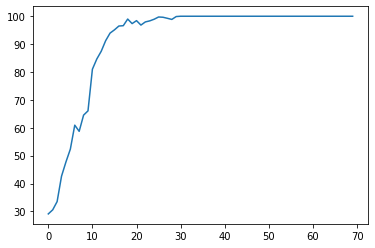

In [13]:
tr_a = np.array(accuracy_train)
plt.plot(tr_a[:,0], tr_a[:,1], label='Train Accuracy')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

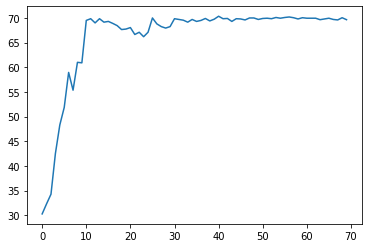

In [14]:
te_a = np.array(accuracy_test)
plt.plot(te_a[:,0], te_a[:,1], label='Test Accuracy')
plt.show